In [13]:
#reuters
from tensorflow.keras.datasets import reuters
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd

## Load Data

In [14]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

## Preprocess Data

In [15]:
word_index = reuters.get_word_index()
 
# Inverting the word index dictionary to decode indices back to words
index_to_word = {index: word for word, index in word_index.items()}
 
# Decoding function
def decode_review(encoded_review):
    return ' '.join([index_to_word.get(i - 3, '?') for i in encoded_review])
 
# Decode the train and test data
train_texts = [decode_review(sequence) for sequence in train_data]
test_texts = [decode_review(sequence) for sequence in test_data]
 
# Create pandas DataFrames
train_df = pd.DataFrame({
    'text': train_texts,
    'label': train_labels
})
 
test_df = pd.DataFrame({
    'text': test_texts,
    'label': test_labels
})
 
# Display the first few rows of the train DataFrame
print(train_df.head())

                                                text  label
0  ? ? ? said as a result of its december acquisi...      3
1  ? generale de banque sa lt ? br and lt heller ...      4
2  ? shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlr...      3
3  ? the farmers home administration the u s agri...      4
4  ? seton co said its board has received a propo...      4


In [16]:
train_df

,text,label
0,? ? ? said as a result of its december acquisi...,3
1,? generale de banque sa lt ? br and lt heller ...,4
2,? shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlr...,3
3,? the farmers home administration the u s agri...,4
4,? seton co said its board has received a propo...,4
...,...,...
8977,? finance minister kiichi miyazawa said japan ...,19
8978,? the price of gold bullion is likely to rise ...,19
8979,? international phoenix energy corp said it la...,25
8980,? shr loss 76 cts vs profit 50 cts net loss 19...,3


In [17]:
test_df

,text,label
0,? the great atlantic and pacific tea co said i...,3
1,? philippine sugar production in the 1987 88 c...,10
2,? the agriculture department's widening of lou...,1
3,? ? ? oil and gas partnership said it complete...,4
4,? strong south ? winds were keeping many vesse...,4
...,...,...
2241,? lt toronto sun publishing corp said it plann...,3
2242,? shr loss 45 cts vs profit 20 cts net loss 1 ...,8
2243,? sept 30 shr 44 cts net 905 000 vs 631 000 si...,3
2244,? inland ? inc said is board proposed a two fo...,3


## Generating Embeddings

In [18]:
# Word2Vec embeddings

from gensim.models import FastText,Word2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords
from nltk.stem import WordNetLemmatizer

# Tokenize the text
def preprocess(text):
    return [
        WordNetLemmatizer().lemmatize(token)
        for token in simple_preprocess(remove_stopwords(text))
    ]

# Preprocess the train and test data
train_df['text'] = train_df['text'].apply(preprocess)
test_df['text'] = test_df['text'].apply(preprocess)

In [19]:
train_df

,text,label
0,"[said, result, december, acquisition, space, e...",3
1,"[generale, banque, sa, lt, br, lt, heller, ove...",4
2,"[shr, dlrs, v, ct, shr, diluted, dlrs, v, ct, ...",3
3,"[farmer, home, administration, agriculture, de...",4
4,"[seton, said, board, received, proposal, chair...",4
...,...,...
8977,"[finance, minister, kiichi, miyazawa, said, ja...",19
8978,"[price, gold, bullion, likely, rise, second, h...",19
8979,"[international, phoenix, energy, corp, said, l...",25
8980,"[shr, loss, ct, v, profit, ct, net, loss, v, p...",3


In [20]:
# tokenize the text
Word2Vec_model = Word2Vec(train_df['text'])

In [21]:
#embedding
def vectorize(text):
    vectors = [Word2Vec_model.wv[word] for word in text if word in Word2Vec_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(Word2Vec_model.vector_size)

# Vectorize the train and test data
X_train = np.stack(train_df['text'].apply(vectorize))
X_test = np.stack(test_df['text'].apply(vectorize))

In [22]:
X_train.shape

(8982, 100)

In [23]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the labels
y_train = to_categorical(train_df['label'])
y_test = to_categorical(test_df['label'])

In [24]:
y_train.shape

(8982, 46)

## Model Training

In [25]:
#train val split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)


In [26]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
import os
import tensorflow as tf


In [27]:
# Checkpoints to save the best Model
model_name = "NN.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=2)

In [28]:
# Defining Model
model = Sequential()
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(46, activation='softmax'))
epochs = 100



In [29]:
# Learning Rate Scheduler -- Change Learning Rate after 60% of epochs
def learning_rate(epoch, lr):
    if epoch < 0.6 * epochs:
        return lr
    else:
        return float(lr * tf.math.exp(-0.008))

lr_scheduler = LearningRateScheduler(learning_rate)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=epochs, batch_size=132, validation_data= (X_val, y_val), callbacks = [lr_scheduler,checkpoint ])

Epoch 1/100
26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2410 - loss: 3.2645 
Epoch 1: val_loss improved from inf to 1.45836, saving model to NN.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3507 - loss: 2.8185 - val_accuracy: 0.6678 - val_loss: 1.4584 - learning_rate: 0.0010
Epoch 2/100
34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6500 - loss: 1.5695 
Epoch 2: val_loss improved from 1.45836 to 1.23512, saving model to NN.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6566 - loss: 1.5269 - val_accuracy: 0.7023 - val_loss: 1.2351 - learning_rate: 0.0010
Epoch 3/100
34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7019 - loss: 1.2651 
Epoch 3: val_loss improved from 1.23512 to 1.13328, saving model to NN.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7014 - loss: 1.2675 - val_accuracy: 0.7279 - val_loss: 1.1333 - learning_rate: 0.0010
Epoch 4/100
40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7127 - loss: 1.1760 
Epoch 4: val

## Evaluation

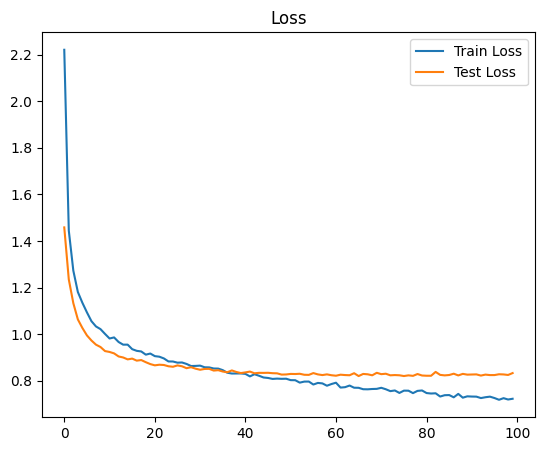

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss')
plt.legend()
plt.show()

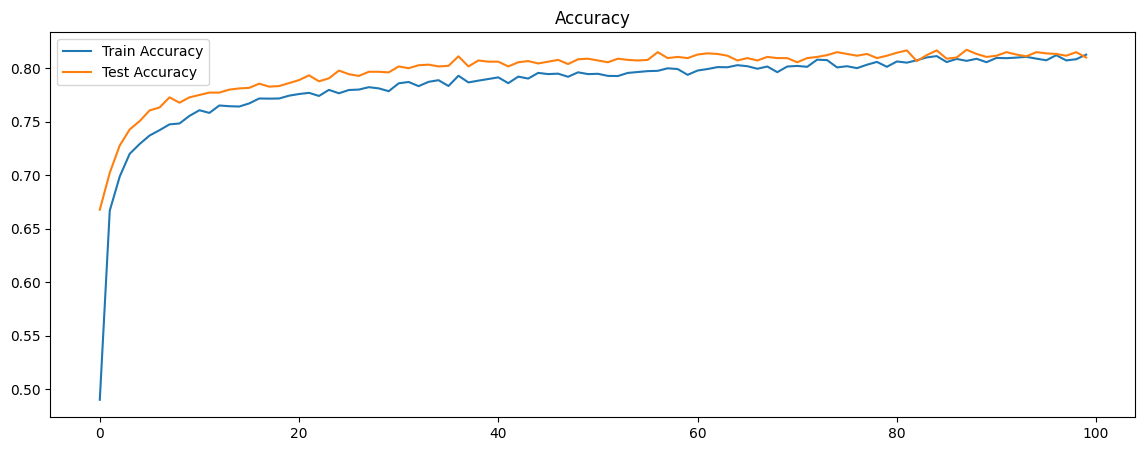

In [31]:
plt.figure(figsize=(14, 5))

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [32]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report

In [33]:
# Load the best model
loaded_model = tf.keras.models.load_model(model_name)

# Predict the test data
y_pred = loaded_model.predict(X_test, verbose=0)
y_pred_train = loaded_model.predict(X_train, verbose = 0)

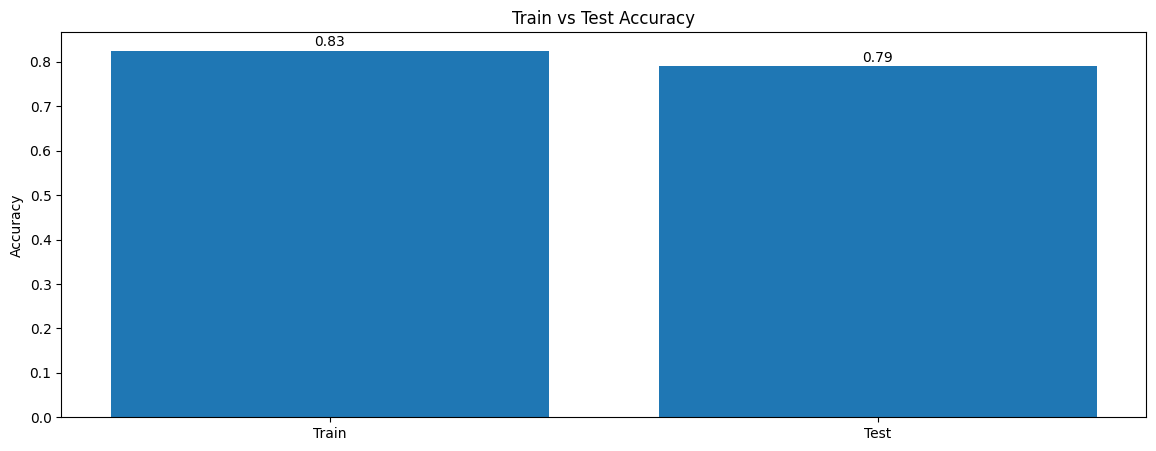

In [34]:


#accuracies
train_acc = accuracy_score([np.argmax(i) for i in y_train],[np.argmax(i) for i in y_pred_train])
test_acc = accuracy_score([np.argmax(i) for i in y_test],[np.argmax(i) for i in y_pred])

# plot
plt.figure(figsize=(14, 5))
plt.bar(['Train', 'Test'], [train_acc, test_acc])
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
for i, v in enumerate([train_acc, test_acc]):
    plt.text(i, v + 0.01, str(round(v, 2)), ha='center')
plt.show()


In [35]:
y_test, y_pred = [np.argmax(i) for i in y_test],[np.argmax(i) for i in y_pred]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.42      0.42        12
           1       0.66      0.70      0.68       105
           2       0.79      0.75      0.77        20
           3       0.92      0.95      0.93       813
           4       0.84      0.88      0.86       474
           5       0.00      0.00      0.00         5
           6       0.50      0.43      0.46        14
           7       1.00      1.00      1.00         3
           8       0.63      0.63      0.63        38
           9       0.80      0.80      0.80        25
          10       0.59      0.80      0.68        30
          11       0.66      0.78      0.72        83
          12       0.70      0.54      0.61        13
          13       0.49      0.68      0.57        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.75      0.84      0.79        99
          17       0.83    

C:\Users\kalli\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kalli\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kalli\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i